In [ ]:
#MOUNT GOOGLE DRIVE
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#IMPORTS

!pip install tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

     |████████████████████████████████| 4.9 MB 6.7 MB/s 
     |████████████████████████████████| 462 kB 52.6 MB/s 


In [ ]:
#load dataset
df = pd.read_csv("stopwords_excluded_final.csv")


#column 'str_processed_tweets' is processed:

#lowercase
#remove url
#remove username
#segment multiword hashtags
#stopwords removed, except for significant stopwords such as negative stop words as "dont, no and positive stop words: would
#stemmed
#lemmatized


##issues with range [-1, +1] with cross entropy loss function, unable to use tanh since keras uses binary cross entropy
##convert range back to [0, 1] w/ threshold as 0.5

#LDA, LSA, BerTopic yeilded bad results
#Idea: any tweet that contained hashtag 'vaccineswork' this includes other provax hashtags -> 1
    #any tweet that contained hashtah 'vaccinesdontwork' this cincludes other antivax hashtags 0
df.head()

,Unnamed: 0,tweet,hashtag,new_tweets,str_processed_tweets,label
0,6518,"in case you needed reason 7,331,6981 to get va...",['vaccineswork'],"['case', 'need', 'reason', 'vaxx', 'vaccin', '...",case needed reason get vaxxed vaccine work,1
1,8036,get vaccinated! #vaccineswork \n,['vaccineswork'],"['vaccin', 'vaccin', 'work']",get vaccinated vaccine work,1
2,7705,join us for a webinar on strategic engagement ...,['vaccineswork'],"['join', 'webinar', 'strateg', 'engag', 'relig...",join u webinar strategic engagement religious ...,1
3,6502,2nd dose of #covishield vaccine done.\ni am pr...,"['covishield', 'covishieldvaccine', 'vaccinefo...","['dose', 'hield', 'vaccin', 'proud', 'vaccin',...",nd dose cov hield vaccine done proud vaccinate...,1
4,5239,anyone else have a doctor who is a pro-vaccine...,"['vaccinesdontwork', 'covidvaccine']","['doctor', 'vaccin', 'democrat', 'refus', 'res...",anyone else doctor pro vaccine democrat refuse...,0


In [ ]:
df.shape

(3844, 6)

In [ ]:
df = df.drop(df.query('label == 1').sample(frac=.4).index)

df['label'].value_counts()

1    1470
0    1394
Name: label, dtype: int64

In [ ]:
#df['str_processed_tweets'].replace({r'[^\x00-\x7F]+':''}, regex=True, inplace=True)

df['str_processed_tweets'][100:105]

134    fucking absurd monstrous think take crack kill...
135    covid vaccine family global community hospital...
136    vaccine do not work outdated spike protein unp...
137    show proof vaccine board case emerged ship omi...
138                             vaccine work canada shot
Name: str_processed_tweets, dtype: object

In [ ]:
#TRAIN TEST SPLIT(80% FOR TRAINING, 20% FOR TESTING)
from sklearn.model_selection import train_test_split

X = df['str_processed_tweets'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=df['label'], test_size=0.2, random_state=10)

In [ ]:
#BERT PREPROCESSING MODEL AND small BERT ENCODER

bert_preprocess_model = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_model = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1")

In [ ]:
#Define custom BERT model that will be fine-tuned for this task

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1", trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_classifier_model()

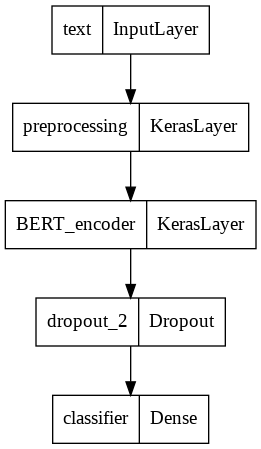

In [ ]:
#model structure
tf.keras.utils.plot_model(classifier_model)

In [ ]:
#binary classification problem, model outputs a probability
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
!pip install -U tf-models-official

In [ ]:
X_train.shape

(2291,)

In [ ]:
#X_train = tf.convert_to_tensor(X_train)

from official.nlp import optimization  # to create AdamW optimizer


epochs = 5
steps_per_epoch = 2291
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
classifier_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128)}                                                

In [ ]:
history = classifier_model.fit(X_train, y_train, epochs=5)

#How to improve? 

#Use larger bert pretrained model(very slow training time ~1hr/epoch)
#use hidden layers

Epoch 1/5
72/72 [==============================] - 591s 8s/step - loss: 0.6977 - binary_accuracy: 0.5225
Epoch 2/5
72/72 [==============================] - 583s 8s/step - loss: 0.6643 - binary_accuracy: 0.5696
Epoch 3/5
72/72 [==============================] - 583s 8s/step - loss: 0.5946 - binary_accuracy: 0.6604
Epoch 4/5
72/72 [==============================] - 586s 8s/step - loss: 0.5283 - binary_accuracy: 0.7224
Epoch 5/5
72/72 [==============================] - 586s 8s/step - loss: 0.4845 - binary_accuracy: 0.7691


In [ ]:
loss, accuracy = classifier_model.evaluate(X_test, y_test)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

18/18 [==============================] - 54s 3s/step - loss: 0.4867 - binary_accuracy: 0.7487
Loss: 0.4867432713508606
Accuracy: 0.7486910820007324


In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' 
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()

In [ ]:
examples = [
    'everyone should get vaccinated they save lives and they work and are safe',
    'vaccines are good!',
    'people who are vaccinated are stupid',
    'vaccines are harmful do not get vaccinated they kill',
    'expose the truth no masks no vaccines',
    'i got vaccinated today and i feel great',
    'fuck vaccines'
]

In [ ]:
results = tf.sigmoid(classifier_model(tf.constant(examples)))
print_my_examples(examples, results)

#1: PROVAX STANCE
#0: ANTIVAX STANCE

input: everyone should get vaccinated they save lives and they work and are safe : score: 0.899951
input: vaccines are good!             : score: 0.661197
input: people who are vaccinated are stupid : score: 0.478935
input: vaccines are harmful do not get vaccinated they kill : score: 0.486034
input: expose the truth no masks no vaccines : score: 0.214180
input: i got vaccinated today and i feel great : score: 0.823324
input: fuck vaccines                  : score: 0.273204



In [ ]:
result = tf.sigmoid(classifier_model(tf.constant(['vaccines are great and are awesome'])))
result[0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.68822885>

In [ ]:
result = tf.sigmoid(classifier_model(tf.constant(['vaccines kill people and have side effects'])))
result[0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=0.4072282>

In [ ]:
classifier_model.save("bert_covid_vaccine_classifier_final", include_optimizer=False)

INFO:tensorflow:Assets written to: bert_covid_vaccine_classifier_final/assets


INFO:tensorflow:Assets written to: bert_covid_vaccine_classifier_final/assets


In [ ]:
reloaded_model = tf.saved_model.load("/content/drive/MyDrive/bert_covid_vaccine_classifier_final")

In [ ]:
results = tf.sigmoid(reloaded_model(tf.constant(examples)))
print_my_examples(examples, results)

input: everyone should get vaccinated they save lives and they work and are safe : score: 0.899951
input: vaccines are good!             : score: 0.661197
input: people who are vaccinated are stupid : score: 0.478935
input: vaccines are harmful do not get vaccinated they kill : score: 0.486034
input: expose the truth no masks no vaccines : score: 0.214180
input: i got vaccinated today and i feel great : score: 0.823324
input: fuck vaccines                  : score: 0.273204

